In [1]:
#Import some modules
import numpy as np
import pandas as pd
from scipy import interp
%matplotlib inline
import matplotlib.pyplot as plt
import model_fitting as mfit
import loan_roi as lr

from sklearn.feature_selection import f_regression, SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
#Read in the training, test, and validation data sets
X_train = pd.read_pickle('X_train')
y_train = pd.read_pickle('y_train')
X_test = pd.read_pickle('X_test')
y_test = pd.read_pickle('y_test')
X_val = pd.read_pickle('X_val')
y_val = pd.read_pickle('y_val')
ROI = pd.read_pickle('ROI')

In [3]:
#Get reliable features without loan amount and interest rate
reliable_feat_no_amnt_intr = mfit.get_reliable_features(X_train.drop(['int_rate', 'loan_amnt'], axis = 1), 
                                                        y_train)

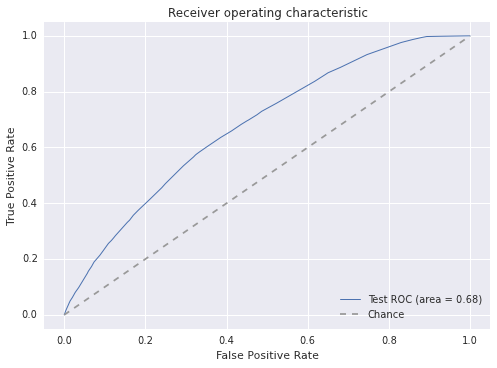

In [5]:
#Fit Decision Tree to training set, plot ROC for test set
DT_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
DT_clf = mfit.fit_clf(X_train[reliable_feat_no_amnt_intr.index[0:9]], y_train,
                         X_test[reliable_feat_no_amnt_intr.index[0:9]], y_test, DT_clf)

/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


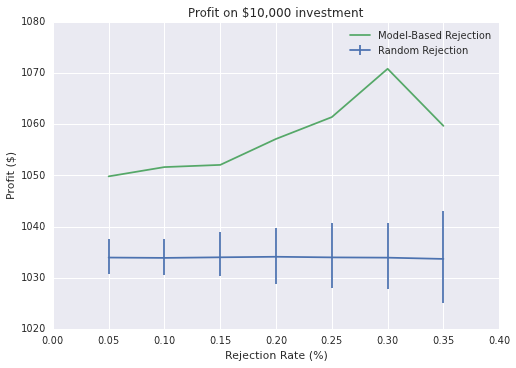

In [6]:
#Look at performance in monetary terms for test set, excluding interest and loan amount
probas_ = DT_clf.predict_proba(X_test[reliable_feat_no_amnt_intr.index[0:9]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_amnt_intr.index[0:9]].index)
pred_ROI = ROI.loc[X_test[reliable_feat_no_amnt_intr.index[0:9]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [7]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1049.798658,1033.931230,1037.522917,1030.770120,1257.844771
0.10,1051.615782,1033.860351,1037.512500,1030.575000,1257.844771
0.15,1052.043518,1033.978508,1038.926826,1030.329836,1257.844771
0.20,1057.120000,1034.083909,1039.758779,1028.766667,1257.844771
0.25,1061.390000,1033.960814,1040.632046,1028.011765,1257.844771
0.30,1070.833228,1033.909510,1040.635132,1027.736378,1257.844771
0.35,1059.671875,1033.661501,1043.120544,1025.088393,1257.844771


In [8]:
#Create dot file for decision tree
from sklearn.tree import export_graphviz
export_graphviz(DT_clf, out_file = "decision_tree.dot", 
                     feature_names = X_train[reliable_feat_no_amnt_intr.index[0:9]].columns, 
                    class_names = ['paid','default'])

Feature ranking:
1. feature last_cred_pl (0.440599)
2. feature dti (0.159787)
3. feature annual_inc (0.116574)
4. feature revol_util (0.114980)
5. feature total_credit_rv (0.092137)
6. feature inq_last_6mths (0.036385)
7. feature for_business (0.018713)
8. feature has_mortgage (0.011588)
9. feature has_rent (0.009237)


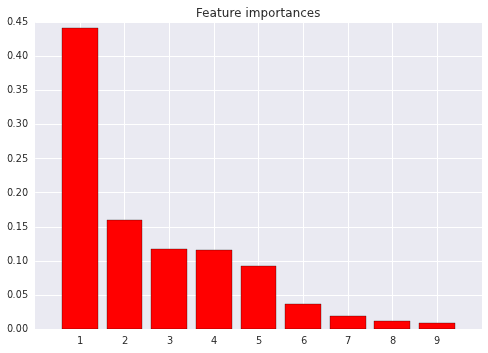

In [9]:
mfit.plot_decision_tree_importance(DT_clf, X_train[reliable_feat_no_amnt_intr.index[0:9]])

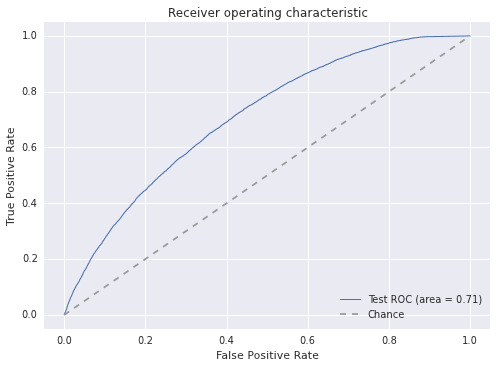

In [31]:
#Fit ensemble of boosted Decision Trees using AdaBoost
clf = DecisionTreeClassifier(max_depth = 2, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
AB_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=100, random_state=42)
AB_clf = mfit.fit_clf(X_train[reliable_feat_no_amnt_intr.index[0:19]], y_train,
                         X_test[reliable_feat_no_amnt_intr.index[0:19]], y_test, AB_clf)

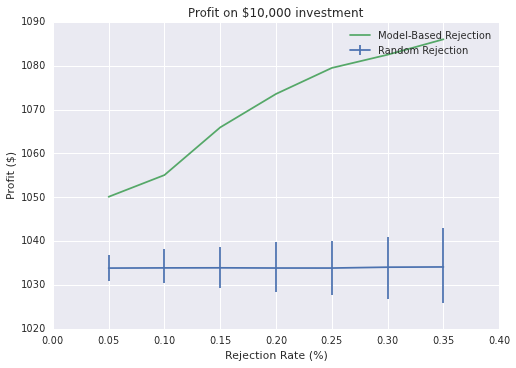

In [32]:
#Look at performance in monetary terms for test set, excluding interest and loan amount
probas_ = AB_clf.predict_proba(X_test[reliable_feat_no_amnt_intr.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_amnt_intr.index[0:19]].index)
pred_ROI = ROI.loc[X_test[reliable_feat_no_amnt_intr.index[0:19]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [33]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1050.109614,1033.847972,1036.754148,1030.901705,1257.844771
0.10,1055.063189,1033.890071,1038.185610,1030.535999,1257.844771
0.15,1065.942857,1033.907956,1038.641667,1029.333333,1257.844771
0.20,1073.571429,1033.862310,1039.708333,1028.379503,1257.844771
0.25,1079.500000,1033.855966,1040.055345,1027.607106,1257.844771
0.30,1082.517865,1034.055143,1040.970958,1026.698042,1257.844771
0.35,1086.029940,1034.105876,1042.916379,1025.921003,1257.844771


Feature ranking:
1. feature last_cred_pl (0.214827)
2. feature revol_util (0.121662)
3. feature total_credit_rv (0.107898)
4. feature dti (0.092804)
5. feature annual_inc (0.082486)
6. feature erlst_cred (0.064166)
7. feature avg_mort_intr (0.049490)
8. feature prop_edu (0.039543)
9. feature inq_last_6mths (0.036897)
10. feature prop_mort_intr (0.027244)
11. feature prop_itemized (0.026958)
12. feature total_acc (0.026627)
13. feature avg_itemized (0.026575)
14. feature avg_inc (0.021617)
15. feature has_rent (0.019619)
16. feature for_business (0.019196)
17. feature has_mortgage (0.014831)
18. feature for_cc (0.005340)
19. feature avg_SS (0.002219)


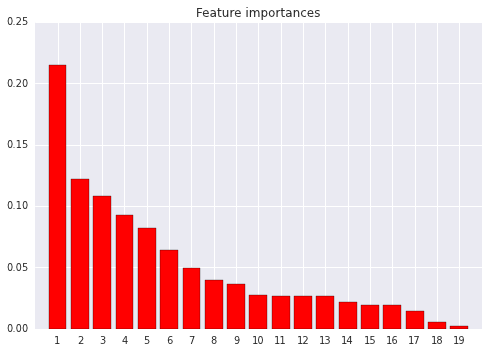

In [34]:
mfit.plot_decision_tree_importance(AB_clf, X_train[reliable_feat_no_amnt_intr.index[0:19]])

In [17]:
#Test performance when adding loan amount back in
reliable_feat_no_intr = mfit.get_reliable_features(X_train.drop(['int_rate'], axis = 1), 
                                                        y_train)

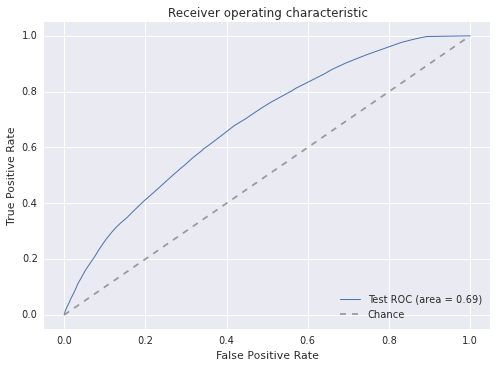

In [18]:
#Fit Decision Tree to training set, plot ROC for test set, include loan amount
DT_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
DT_clf = mfit.fit_clf(X_train[reliable_feat_no_intr.index[0:24]], y_train,
                         X_test[reliable_feat_no_intr.index[0:24]], y_test, DT_clf)

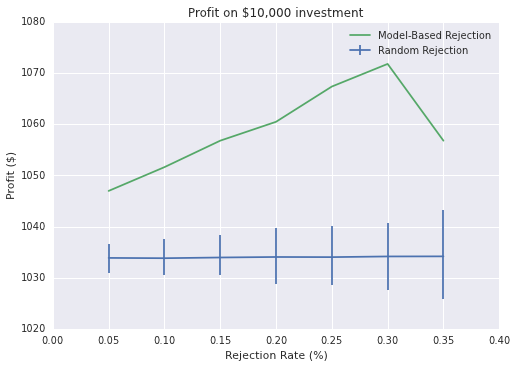

In [19]:
#Look at performance in monetary terms for validation set, excluding interest and loan amount
probas_ = DT_clf.predict_proba(X_test[reliable_feat_no_intr.index[0:24]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_intr.index[0:24]].index)
pred_ROI = ROI.loc[X_test[reliable_feat_no_intr.index[0:24]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [20]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1046.956250,1033.859191,1036.668831,1030.918919,1257.844771
0.10,1051.604167,1033.802926,1037.578303,1030.539271,1257.844771
0.15,1056.779167,1033.940844,1038.342083,1030.465269,1257.844771
0.20,1060.468983,1034.039812,1039.619921,1028.840990,1257.844771
0.25,1067.361915,1034.013056,1040.101449,1028.501593,1257.844771
0.30,1071.785714,1034.145297,1040.634995,1027.510000,1257.844771
0.35,1056.779167,1034.161344,1043.144780,1025.908815,1257.844771


In [21]:
#Create dot file for decision tree
from sklearn.tree import export_graphviz
export_graphviz(DT_clf, out_file = "decision_tree_wAmnt.dot", 
                     feature_names = X_train[reliable_feat_no_intr.index[0:24]].columns, 
                    class_names = ['paid','default'])

Feature ranking:
1. feature last_cred_pl (0.390532)
2. feature loan_amnt (0.151018)
3. feature dti (0.127671)
4. feature annual_inc (0.122903)
5. feature total_credit_rv (0.078268)
6. feature revol_util (0.069135)
7. feature inq_last_6mths (0.016056)
8. feature erlst_cred (0.009428)
9. feature has_mortgage (0.009279)
10. feature has_rent (0.008316)
11. feature prop_st_loans (0.006702)
12. feature total_acc (0.005513)
13. feature for_business (0.005125)
14. feature avg_inc (0.000053)
15. feature mnths_since_delinq_1st (0.000000)
16. feature for_other (0.000000)
17. feature for_cc (0.000000)
18. feature avg_itemized (0.000000)
19. feature avg_mort_intr (0.000000)
20. feature prop_itemized (0.000000)
21. feature avg_SS (0.000000)
22. feature prop_mort_intr (0.000000)
23. feature for_debt (0.000000)
24. feature prop_edu (0.000000)


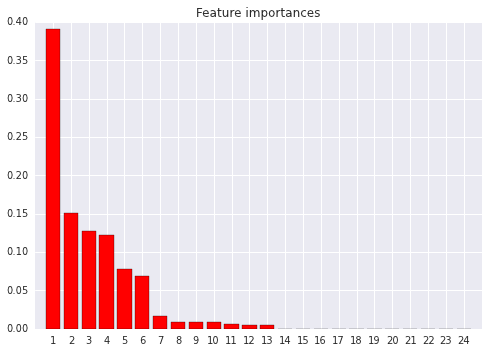

In [22]:
mfit.plot_decision_tree_importance(DT_clf, X_train[reliable_feat_no_intr.index[0:24]])

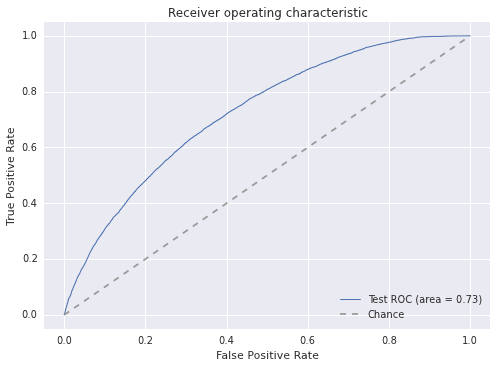

In [27]:
#Fit ensemble of boosted Decision Trees using AdaBoost including loan amount
clf = DecisionTreeClassifier(max_depth = 2, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
AB_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=100, random_state=42)
AB_clf = mfit.fit_clf(X_train[reliable_feat_no_intr.index[0:19]], y_train,
                         X_test[reliable_feat_no_intr.index[0:19]], y_test, AB_clf)

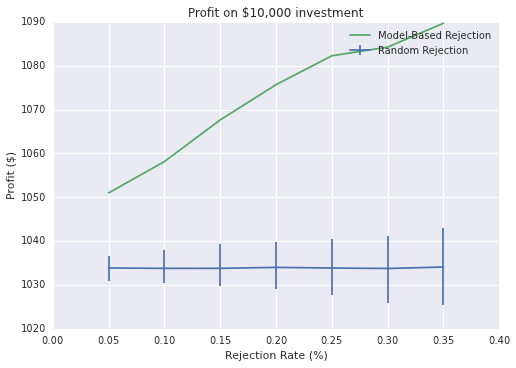

In [29]:
#Look at performance in monetary terms for test set, including loan amount
probas_ = AB_clf.predict_proba(X_test[reliable_feat_no_intr.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat_no_intr.index[0:19]].index)
pred_ROI = ROI.loc[X_test[reliable_feat_no_intr.index[0:19]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [30]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1050.992703,1033.873920,1036.688469,1030.902317,1257.844771
0.10,1058.148526,1033.786225,1037.982917,1030.514860,1257.844771
0.15,1067.650000,1033.792750,1039.293375,1029.774085,1257.844771
0.20,1075.680146,1034.011428,1039.763698,1029.145052,1257.844771
0.25,1082.270000,1033.864198,1040.576148,1027.739038,1257.844771
0.30,1084.247917,1033.760950,1041.179965,1025.946199,1257.844771
0.35,1089.688889,1034.087723,1043.013991,1025.400735,1257.844771


Feature ranking:
1. feature last_cred_pl (0.124946)
2. feature total_credit_rv (0.112838)
3. feature annual_inc (0.100566)
4. feature dti (0.091143)
5. feature revol_util (0.089473)
6. feature loan_amnt (0.070917)
7. feature erlst_cred (0.062522)
8. feature prop_edu (0.059196)
9. feature prop_itemized (0.044003)
10. feature total_acc (0.043860)
11. feature inq_last_6mths (0.038048)
12. feature avg_mort_intr (0.035802)
13. feature avg_inc (0.035366)
14. feature avg_itemized (0.028981)
15. feature avg_SS (0.023496)
16. feature for_cc (0.013205)
17. feature for_business (0.009650)
18. feature has_mortgage (0.009121)
19. feature has_rent (0.006867)


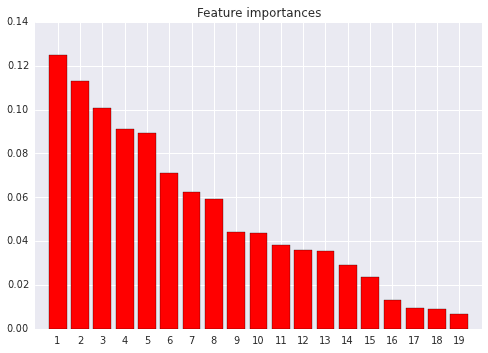

In [26]:
mfit.plot_decision_tree_importance(AB_clf, X_train[reliable_feat_no_intr.index[0:19]])

In [35]:
#Test performance when adding interest rate back in
reliable_feat = mfit.get_reliable_features(X_train, y_train)

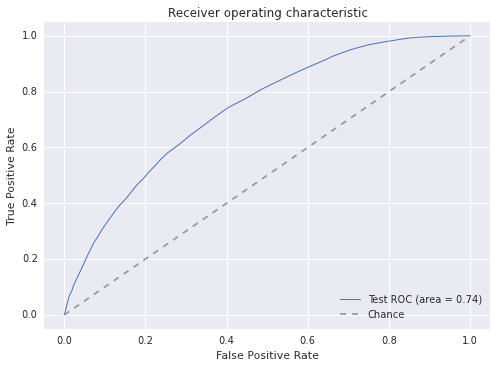

In [36]:
#Fit Decision Tree to training set, plot ROC for test set
DT_clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 5, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
DT_clf = mfit.fit_clf(X_train[reliable_feat.index[0:24]], y_train,
                         X_test[reliable_feat.index[0:24]], y_test, DT_clf)

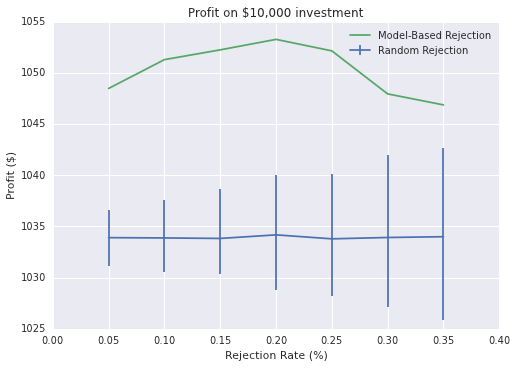

In [37]:
#Look at performance in monetary terms for test set
probas_ = DT_clf.predict_proba(X_test[reliable_feat.index[0:24]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat.index[0:24]].index)
pred_ROI = ROI.loc[X_test[reliable_feat.index[0:24]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [38]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1048.494700,1033.910337,1036.581818,1031.166259,1257.844771
0.10,1051.310872,1033.881738,1037.604083,1030.564979,1257.844771
0.15,1052.266646,1033.833018,1038.641667,1030.351336,1257.844771
0.20,1053.291572,1034.182825,1040.042857,1028.763516,1257.844771
0.25,1052.168608,1033.794562,1040.155564,1028.192388,1257.844771
0.30,1047.962963,1033.925702,1042.031054,1027.111170,1257.844771
0.35,1046.886685,1034.001609,1042.661540,1025.874383,1257.844771


Feature ranking:
1. feature int_rate (0.483180)
2. feature last_cred_pl (0.293562)
3. feature annual_inc (0.112135)
4. feature dti (0.040000)
5. feature loan_amnt (0.036396)
6. feature revol_util (0.012083)
7. feature inq_last_6mths (0.010418)
8. feature has_rent (0.004354)
9. feature prop_itemized (0.003159)
10. feature avg_mort_intr (0.002321)
11. feature total_credit_rv (0.002308)
12. feature total_acc (0.000060)
13. feature prop_st_loans (0.000024)
14. feature has_mortgage (0.000000)
15. feature for_other (0.000000)
16. feature for_business (0.000000)
17. feature prop_edu (0.000000)
18. feature for_cc (0.000000)
19. feature avg_itemized (0.000000)
20. feature erlst_cred (0.000000)
21. feature avg_SS (0.000000)
22. feature prop_mort_intr (0.000000)
23. feature for_debt (0.000000)
24. feature avg_inc (0.000000)


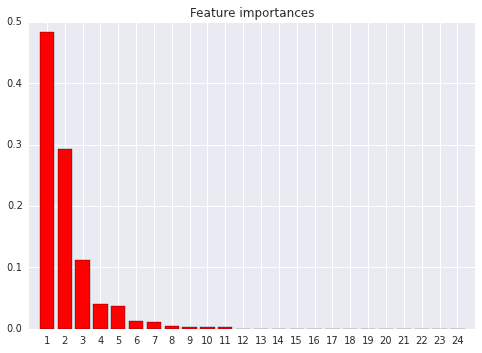

In [39]:
mfit.plot_decision_tree_importance(DT_clf, X_train[reliable_feat.index[0:24]])

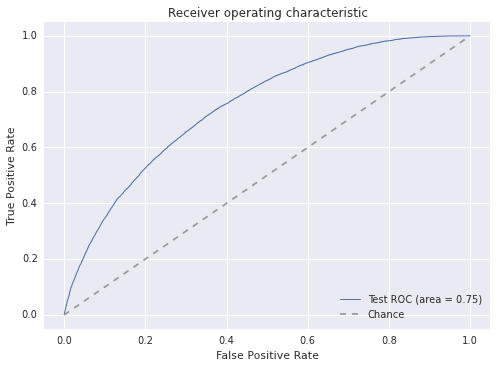

In [42]:
#Fit ensemble of boosted Decision Trees using AdaBoost
clf = DecisionTreeClassifier(max_depth = 2, class_weight = {0: (1.0 - 0.1841), 1: 0.1841})
AB_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=100, random_state=42)
AB_clf = mfit.fit_clf(X_train[reliable_feat.index[0:19]], y_train,
                         X_test[reliable_feat.index[0:19]], y_test, AB_clf)

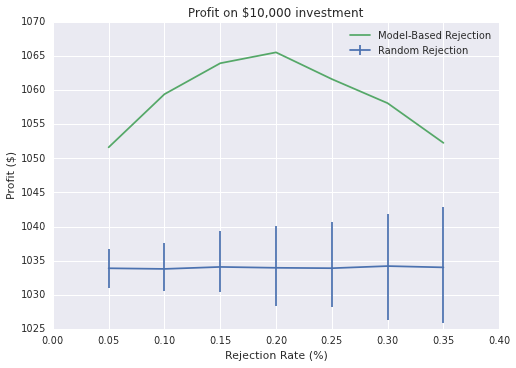

In [43]:
#Look at performance in monetary terms for test set
probas_ = AB_clf.predict_proba(X_test[reliable_feat.index[0:19]])
prob_default = pd.Series(data = probas_[:,1], index=X_test[reliable_feat.index[0:19]].index)
pred_ROI = ROI.loc[X_test[reliable_feat.index[0:19]].index]
pred_ROI['default'] = y_test
b = 10000
p_rej = np.arange(0.05, 0.4, 0.05)
val_frame = lr.model_perf_dollars(pred_ROI, prob_default, p_rej, 'default', 'roi', 0)

In [44]:
val_frame

,reject,random,random_hi_ci,random_lo_ci,perfect
0.05,1051.609974,1033.875390,1036.695921,1030.974490,1257.844771
0.10,1059.397636,1033.780775,1037.588820,1030.523935,1257.844771
0.15,1063.938889,1034.071098,1039.328000,1030.333333,1257.844771
0.20,1065.531983,1033.944277,1040.042857,1028.377778,1257.844771
0.25,1061.613333,1033.886400,1040.630036,1028.137500,1257.844771
0.30,1058.082652,1034.196556,1041.880908,1026.289738,1257.844771
0.35,1052.263096,1034.006205,1042.899683,1025.790667,1257.844771


Feature ranking:
1. feature last_cred_pl (0.191048)
2. feature int_rate (0.122912)
3. feature total_credit_rv (0.100091)
4. feature loan_amnt (0.096574)
5. feature erlst_cred (0.075985)
6. feature annual_inc (0.070399)
7. feature revol_util (0.056083)
8. feature avg_mort_intr (0.049164)
9. feature dti (0.048180)
10. feature prop_itemized (0.042898)
11. feature total_acc (0.035581)
12. feature prop_edu (0.030303)
13. feature inq_last_6mths (0.025839)
14. feature avg_itemized (0.019832)
15. feature avg_inc (0.017180)
16. feature has_mortgage (0.007812)
17. feature for_business (0.005153)
18. feature has_rent (0.002928)
19. feature for_cc (0.002038)


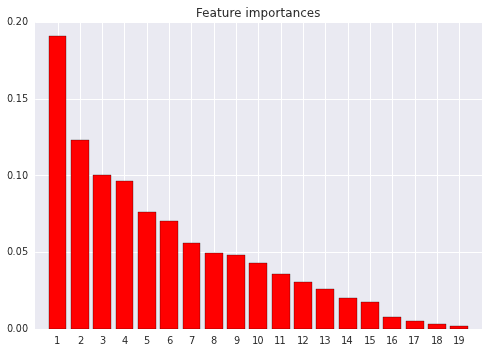

In [45]:
mfit.plot_decision_tree_importance(AB_clf, X_train[reliable_feat.index[0:19]])